In [ ]:
# rappatrier les données brutes depuis le bucket S3
%run "../src/data/getRawData.py"

downloading raw data from bucket


In [ ]:
# Chargement des données brutes
import pandas as pd

df = pd.read_csv("../data/raw_data/raw.csv")
df.head()

,date,ave_flot_air_flow,ave_flot_level,iron_feed,starch_flow,amina_flow,ore_pulp_flow,ore_pulp_pH,ore_pulp_density,silica_concentrate
0,2017-04-24 00:00:00,300.263166,383.982443,55.17,1979.589150,599.676489,400.017222,9.774028,1.753206,4.360000
1,2017-04-24 01:00:00,299.782402,386.049069,55.17,1758.466329,600.043100,400.484528,9.539246,1.754190,3.290000
2,2017-04-24 02:00:00,299.750052,385.250935,55.17,2379.752428,599.948406,400.325617,9.434227,1.756873,4.900000
3,2017-04-24 03:00:00,299.997522,389.635519,55.17,2287.130046,599.580383,399.801506,9.725607,1.727125,4.860153
4,2017-04-24 04:00:00,300.005220,387.810807,55.17,2291.789167,599.871217,399.567333,9.845198,1.633063,4.780898


In [ ]:
# Analyse de l'attribut date

df['date'] = pd.to_datetime(df['date'])

df['annee'] = df['date'].dt.year
df['mois'] = df['date'].dt.month
df['jour_mois'] = df['date'].dt.day
df['heure'] = df['date'].dt.hour

print(df.annee.value_counts())
print(df.mois.value_counts())

# Après cette rapide analyse du comportement du champs date, je fais l'hypothèse que nous ne sommes pas sur une problématique
# de série temporelle et qu'il s'agit du timestamp de relevés réguliers durant une période d'observation déterminée.
# Je vais donc m'affranchir de la date

df = df.select_dtypes(include=['float64'])
df.describe()

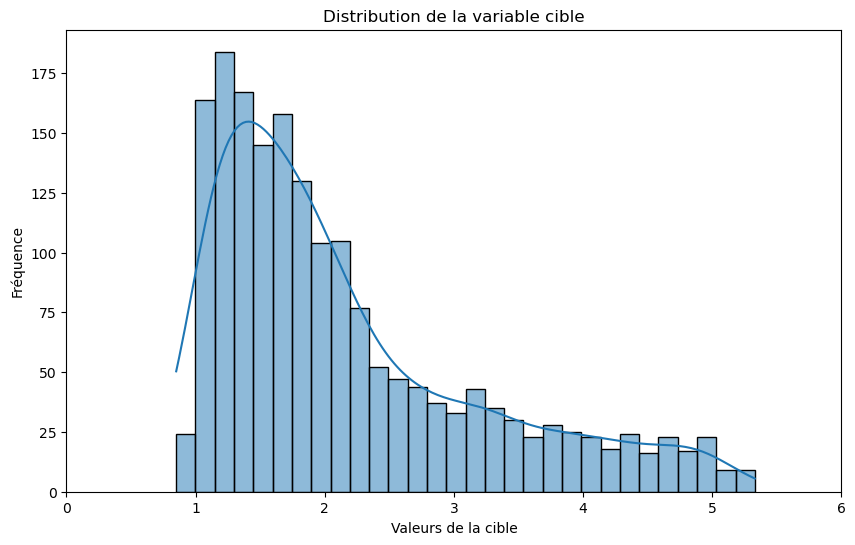

In [ ]:
# Appréciation de la distribution de la variable cible

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['silica_concentrate'], kde=True, bins=30) 
plt.title("Distribution de la variable cible")
plt.xlabel("Valeurs de la cible")
plt.ylabel("Fréquence")
plt.xlim(0, 6)  
plt.show()


In [ ]:
# split des données en sets d'entraînement et de test

from sklearn.model_selection import train_test_split

X = df.drop(columns=['silica_concentrate'])
y = df['silica_concentrate']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.to_csv("../data/processed_data/X_train.csv", index=False)
X_test.to_csv("../data/processed_data/X_test.csv", index=False)
y_train.to_csv("../data/processed_data/y_train.csv", index=False)
y_test.to_csv("../data/processed_data/y_test.csv", index=False)

In [ ]:
# Normalisation des données
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

X_train_scaled.describe()

X_train_scaled.to_csv("../data/processed_data/X_train_scaled.csv", index=False)
X_test_scaled.to_csv("../data/processed_data/X_test_scaled.csv", index=False)

In [ ]:
# test RF
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print(f"R² Random Forest : {r2_score(y_test, y_pred_rf):.4f}")


R² Random Forest : 0.2113


In [ ]:
# GridSearchCV
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2', 'sqrt'],
    'bootstrap': [True]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

print(f"Meilleur score R² (CV) : {grid_search.best_score_:.4f}")
print("Meilleurs paramètres :", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² : {r2:.4f}")
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")

with open("models/best_random_forest_params.pkl", 'wb') as f:
    pickle.dump(grid_search.best_params_, f)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Meilleur score R² (CV) : 0.2100
Meilleurs paramètres : {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
R² : 0.2192
MSE : 0.7815
RMSE : 0.8840
MAE : 0.6887
